In [19]:
# imports
import torch 
import torchvision
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torchvision.datasets as datasets # Standard datasets
from torch.utils.data import Dataset # Gives easier dataset management and creates mini batches
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from torch.autograd import Variable



In [20]:
df = pd.read_csv('AirPassengers.csv')

# information about the data
print(df.head())
print(df.info())


     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None


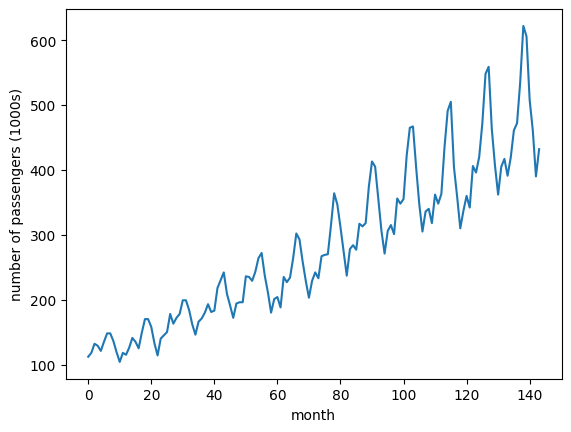

In [21]:
training_set = df.iloc[:,1:2].values
plt.xlabel('month')
plt.ylabel('number of passengers (1000s)')
plt.plot(training_set)
plt.show()



In [46]:

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)
training_data.shape


# create sequences
seq_length = 5
x = []
y = []
for i in range(len(training_data)-seq_length-1):
    
    x.append(training_data[i:i+seq_length])
    y.append(training_data[i+seq_length])
   

In [47]:
# Use gpu if available
device = torch.device('mps')

In [48]:
train_size = int(len(y) * 0.7) # 70% of the data is used for training
test_size = len(y) - train_size # 30% of the data is used for testing


dataX = torch.Tensor(np.array(x)).float() # convert to tensors
dataY = torch.Tensor(np.array(y)).float() # convert to tensors

trainX = torch.Tensor(np.array(x[0:train_size]))
trainY = torch.Tensor(np.array(y[0:train_size]))
testX = torch.Tensor(np.array(x[train_size:len(x)]))
testY = torch.Tensor(np.array(y[train_size:len(y)]))



In [76]:
# Set hyperparameters for BI-LSTM and also LSTM
input_size = 1
hidden_size = 2
num_layers = 2
num_classes = 1
num_epochs = 2000
learning_rate = 0.01


# build class Bi LSTM 
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()


        self.input_size = input_size
        self.hidden_size = hidden_size

        # Because number of layers is 1, we can use the same number of layers for the forward and backward LSTM
        # But if you want Bi-stack LSTM, you can update the number of layers for the forward and backward LSTM
        self.num_layers = num_layers
        self.num_classes = num_classes

        self.bilstm = nn.LSTM(input_size=input_size,  hidden_size=hidden_size,  num_layers=num_layers, batch_first=True, bidirectional=True)

        # Because this is a bidirectional LSTM, the input size for the fully connected layer is 2*hidden_size
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
            
            h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) 
            c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) 


             # Propagate input through LSTM
            out, _ = self.bilstm(x, (h0, c0))
            out = out[:, -1, :]
            out = self.fc(out)
            return out
    



class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()


        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes

        self.lstm = nn.LSTM(input_size=input_size,  hidden_size=hidden_size,  num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
            
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 


             # Propagate input through LSTM
            out, _ = self.lstm(x, (h0, c0))
            out = out[:, -1, :]
            out = self.fc(out)
            return out
    


class StackLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(StackLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.num_layers = num_layers
        self.num_classes = num_classes

        self.lstm = nn.LSTM(input_size=input_size,  hidden_size=hidden_size,  num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
            
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
             # Propagate input through LSTM
            out, _ = self.lstm(x, (h0, c0))
            out = out[:, -1, :]
            out = self.fc(out)
            return out
    

In [77]:



# lstm = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
lstm = StackLSTM(input_size, hidden_size, num_layers, num_classes).to(device)
# BiLSTM
#lstm = BiLSTM(input_size, hidden_size, num_layers, num_classes).to(device)

In [78]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)


In [79]:


# train network 
for epoch in range(num_epochs):
    outputs = lstm(trainX.to(device))  # Move input data to GPU
    optimizer.zero_grad()

    loss = criterion(outputs, trainY.to(device)) # Move target data to GPU
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


Epoch: 0, loss: 0.52587
Epoch: 100, loss: 0.01889
Epoch: 200, loss: 0.00363
Epoch: 300, loss: 0.00248
Epoch: 400, loss: 0.00197
Epoch: 500, loss: 0.00181
Epoch: 600, loss: 0.00173
Epoch: 700, loss: 0.00170
Epoch: 800, loss: 0.00167
Epoch: 900, loss: 0.00166
Epoch: 1000, loss: 0.00165
Epoch: 1100, loss: 0.00164
Epoch: 1200, loss: 0.00162
Epoch: 1300, loss: 0.00160
Epoch: 1400, loss: 0.00158
Epoch: 1500, loss: 0.00156
Epoch: 1600, loss: 0.00154
Epoch: 1700, loss: 0.00152
Epoch: 1800, loss: 0.00150
Epoch: 1900, loss: 0.00148


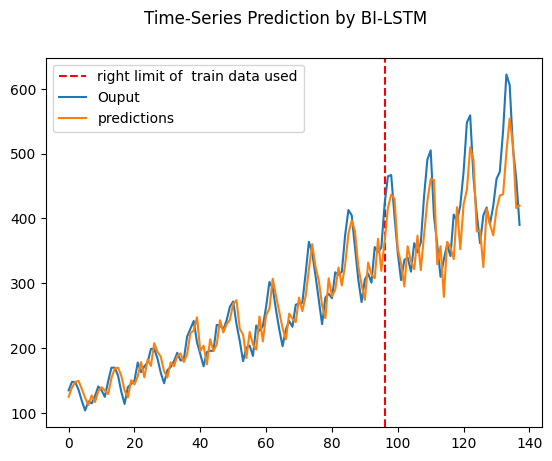

In [56]:
lstm.eval()

# predict on training and test data
all_predict = lstm(dataX.to(device)).cpu()

data_predict = all_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--', label='right limit of  train data used')

plt.plot(dataY_plot, label='Ouput')
plt.plot(data_predict, label='predictions')
plt.suptitle('Time-Series Prediction by BI-LSTM')
plt.legend()
plt.show()
     

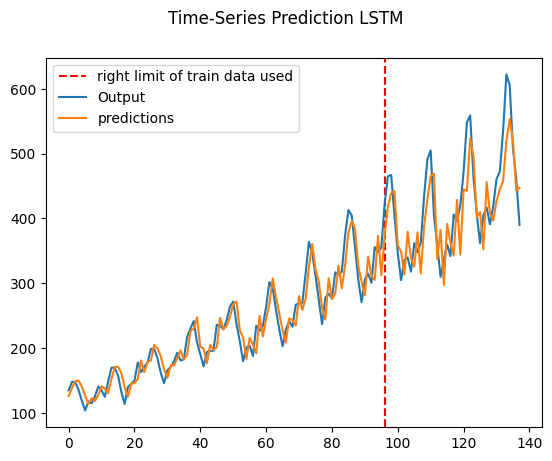

In [60]:
lstm.eval()

# predict on training and test data
all_predict = lstm(dataX.to(device)).cpu()

data_predict = all_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--', label='right limit of train data used')

plt.plot(dataY_plot, label='Output')
plt.plot(data_predict, label='predictions')
plt.suptitle('Time-Series Prediction LSTM')
plt.legend()
plt.show()
     

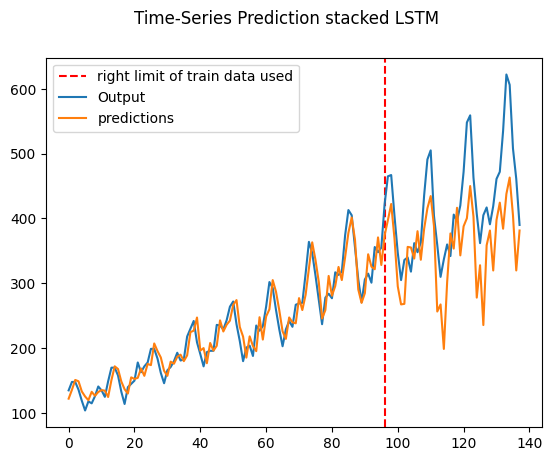

In [80]:
lstm.eval()

# predict on training and test data
all_predict = lstm(dataX.to(device)).cpu()

data_predict = all_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--', label='right limit of train data used')

plt.plot(dataY_plot, label='Output')
plt.plot(data_predict, label='predictions')
plt.suptitle('Time-Series Prediction stacked LSTM')
plt.legend()
plt.show()
     

# Stocks 